In [153]:
import astropy.units as u
from spectrum import CosmicRaySpectrum, CrabSpectrum, CTAElectronSpectrum, MCSpectrum, make_energy_bins
import fact.io

from astropy.coordinates import Angle
from astropy.coordinates.angle_utilities import angular_separation

from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fact.analysis import li_ma_significance
from scipy.optimize import brute
from scipy.optimize import minimize_scalar
from tqdm import tqdm
%matplotlib inline

In [154]:
n_bins = 20

gamma_input = '../../cta_rta_analysis/build/gammas_test.hdf5'
proton_input = '../../cta_rta_analysis/build/protons_test.hdf5'

t_obs = 50 * u.h
e_min, e_max = 0.02 * u.TeV, 200 * u.TeV
bin_edges, bin_center, bin_width = make_energy_bins(e_min=e_min, e_max=e_max, bins=n_bins, centering='log')

columns = ['gamma_prediction_mean', 'gamma_energy_prediction_mean', 'az_prediction', 'alt_prediction', 'mc_alt', 'mc_az', 'mc_energy', 'num_triggered_telescopes']

gammas = fact.io.read_data(gamma_input, key='array_events', columns=columns)
gammas = gammas.dropna()
gammas['type'] = 0
gamma_runs = fact.io.read_data(gamma_input, key='runs')
mc_production_gamma = MCSpectrum.from_cta_runs(gamma_runs)

protons = fact.io.read_data(proton_input, key='array_events', columns=columns)
protons = protons.dropna()
protons['type'] = 1
proton_runs = fact.io.read_data(proton_input, key='runs')
mc_production_proton = MCSpectrum.from_cta_runs(proton_runs)

crab = CrabSpectrum()
cosmic_proton = CosmicRaySpectrum()

gammas['weight'] = mc_production_gamma.reweigh_to_other_spectrum(crab, gammas.mc_energy.values * u.TeV, t_assumed_obs=t_obs)
protons['weight'] = mc_production_proton.reweigh_to_other_spectrum(cosmic_proton, protons.mc_energy.values * u.TeV, t_assumed_obs=t_obs)

print(gammas.columns)

print(len(protons))
print(len(gammas))

Index(['gamma_prediction_mean', 'gamma_energy_prediction_mean',
       'az_prediction', 'alt_prediction', 'mc_alt', 'mc_az', 'mc_energy',
       'num_triggered_telescopes', 'type', 'weight'],
      dtype='object')
6600927
980458


In [155]:
def calculate_theta(df, source_alt=70 * u.deg, source_az=0 * u.deg):
    source_az = Angle(source_az).wrap_at(180 * u.deg)
    source_alt = Angle(source_alt)

    az = Angle(df.az_prediction.values, unit=u.rad).wrap_at(180*u.deg)
    alt = Angle(df.alt_prediction.values, unit=u.rad)

    return angular_separation(source_az, source_alt, az, alt).to(u.deg).value

gammas['theta'] = calculate_theta(gammas)
protons['theta'] = calculate_theta(protons)

In [156]:
def count_events_in_region(df, theta2=0.03, prediction_threshold=0.5):
    m = ((df.theta**2 <= theta2) & (df.gamma_prediction_mean >= prediction_threshold))
    return df[m].weight.sum(), m.sum()


def extrapolate_off_events(df, theta2=0.03, prediction_threshold=0.5, sigma=1):
    if prediction_threshold == 1:
        return 0
    df = df.query('theta < 1.0')
    
    c_bins = np.linspace(0, 1, 30)
    c_bin_center = (c_bins[0:-1] + c_bins[1:])/2
    c_bin_width = np.diff(c_bins)
    nodes = c_bin_center + c_bin_width

    h, _ = np.histogram(df.gamma_prediction_mean, bins=c_bins, weights=df.weight)
    h = gaussian_filter(h, sigma=sigma)
    h = np.sum(h) - np.cumsum(h)
    background = interp1d(nodes, h, kind=1, fill_value='extrapolate', bounds_error=False)
    
    
    h, _ = np.histogram(df.gamma_prediction_mean, bins=c_bins)
    h = gaussian_filter(h, sigma=sigma)
    h = np.sum(h) - np.cumsum(h)
    counts = interp1d(nodes, h, kind=1, fill_value='extrapolate', bounds_error=False)
    
    return background(prediction_threshold) * theta2, counts(prediction_threshold) * theta2 



def count_off_events_in_region(df, theta2=0.03, prediction_threshold=0.5):
    df = df.query('theta < 1.0')
    m = df.gamma_prediction_mean >= prediction_threshold
#     m = ((df.theta**2 <= theta2) & (df.gamma_prediction_mean >= prediction_threshold))
    return df[m].weight.sum() * theta2, m.sum() * theta2


def select_events_in_energy_range(signal, background, e_low, e_high, use_true_energy=False):
    
    column = 'mc_energy' if use_true_energy else 'gamma_energy_prediction_mean'
    m = ((signal[column] > e_low ) & (signal[column] < e_high ))
    s = signal[m]

    m = ((background[column] > e_low ) & (background[column] < e_high ))
    b = background[m]
    return s, b

def scaling_factor(n_signal, n_background, t_signal, t_background, alpha=1, N=200): 
    
    right_bound = 100

    def target(scaling_factor, n_signal, n_background, alpha=1, sigma=5):
        n_on = n_background*alpha + n_signal * scaling_factor
        n_off = n_background
        
        significance = li_ma_significance(n_on, n_off, alpha=alpha)
        return (5 - significance)**2
    
#     print(t_background, n_background, '---------', t_signal, n_signal)
    n_signal = np.random.poisson(t_signal, size=N) * n_signal / t_signal
    n_background = np.random.poisson(t_background, size=N) * n_background / t_background
    
    
    hs = []
    for signal, background in zip(n_signal, n_background):
        if background == 0:
            hs.append(np.nan)
        else:
            result = minimize_scalar(target, args=(signal, background, alpha), bounds=(0, right_bound), method='bounded').x
            if np.allclose(result, right_bound):
                result = np.nan
            hs.append(result)
    return np.nanpercentile(np.array(hs), (50, 5, 95))


# regions=slice(0.015, 0.02, 0.0025), thresholds=slice(0.8, 9, 0.05)
#regions=slice(0.0025, 0.07, 0.0025), thresholds=slice(0.3, 1, 0.05)
def find_best_cuts(signal, background, alpha, regions=slice(0.0025, 0.08, 0.01), thresholds=slice(0.4, 1, 0.05), method='simple'):
    
    def significance_target(cuts, signal, background, alpha):
        theta2, p_cut = cuts
        n_signal, t_signal = count_events_in_region(signal, theta2=theta2, prediction_threshold=p_cut)

        if method == 'exact':
            n_background, t_background = count_events_in_region(background, theta2=theta2/alpha, prediction_threshold=p_cut)
                                
            if t_background < 10:
                print(f'{cuts} not enough background')
                return 0
            
        elif method == 'simple':
            n_background, t_background = count_off_events_in_region(background, theta2=theta2/alpha, prediction_threshold=p_cut)
                    
            if t_background/alpha < 10:
                print(f'{cuts} not enough background')
                return 0
        
        elif method == 'extrapolate':
            n_background, t_background = extrapolate_off_events(background, theta2=theta2/alpha, prediction_threshold=p_cut)

        
#         if t_background/alpha < 1:
#             print(f'{cuts} not enough background')
#             return 0
            
        if t_signal <= t_background * alpha + 10:
            print('counts not large enough')
            return 0
        
        
        if t_signal <= t_background * alpha + 10:
            print('signal not large enough')
            return 0
        if n_signal*5 < n_background * 0.01:
            print('sys problem')
            return 0
            
                
        n_on = n_signal + alpha*n_background
        n_off = n_background
        return -li_ma_significance(n_on, n_off, alpha=alpha)

    result = brute(significance_target, ranges=[regions, thresholds], args=(signal, background, alpha), finish=None)
    print(result)
    return result


def calc_relative_sensitivity(signal, background, bin_edges, alpha=1, use_true_energy=False, method='simple'):
    relative_sensitivities = []
    thresholds = []
    thetas = []
    for e_low, e_high in tqdm(zip(bin_edges[:-1], bin_edges[1:])):
        s, b = select_events_in_energy_range(signal, background, e_low, e_high, use_true_energy=use_true_energy)
        
        theta2, cut = find_best_cuts(s, b, alpha=alpha, method=method)

        n_signal, t_signal = count_events_in_region(s, theta2=theta2, prediction_threshold=cut)

        if method == 'simple':
            n_background, t_background = count_off_events_in_region(b, theta2=theta2/alpha, prediction_threshold=cut)
#             extra = extrapolate_off_events(b, theta2=theta2/alpha, prediction_threshold=cut)
#             print(f'Extrapolated: {extra}, Simple{(n_background, t_background)}')
        elif method == 'exact':
            n_background, t_background = count_events_in_region(b, theta2=theta2/alpha, prediction_threshold=cut)    
        elif method == 'extrapolate':
            n_background, t_background = extrapolate_off_events(b, theta2=theta2/alpha, prediction_threshold=cut)

        print(t_background, t_signal)
        rs = scaling_factor(n_signal, n_background, t_signal, t_background, alpha=alpha)
        relative_sensitivities.append(rs)
        thresholds.append(cut)
        thetas.append(np.sqrt(theta2))
        
       
        
    m, l, h = np.array(relative_sensitivities).T
    d = {'sensitivity': m, 'sensitivity_low': l, 'sensitivity_high': h, 'threshold':thresholds, 'theta':thetas}
    return pd.DataFrame(d)



In [158]:
def plot_sensitivity(rs, crab, bin_edges, bin_center, color='blue', **kwargs):
    sensitivity = rs.sensitivity.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_low = rs.sensitivity_low.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_high = rs.sensitivity_high.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    yerr = [np.abs(sensitivity - sensitivity_low).value, np.abs(sensitivity - sensitivity_high).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, yerr=yerr, linestyle='', ecolor=color, **kwargs)

    plt.xscale('log')
    plt.yscale('log')
    plt.plot(bin_edges, crab.flux(bin_edges) * bin_edges**2, '--', color='gray')
    plt.ylim([1E-14, 1E-9])
    
    path = '../resources/ascii/CTA-Performance-prod3b-v1-South-20deg-50h-DiffSens.txt'
    df = pd.read_csv(path, delimiter='\t\t', skiprows=10, names=['e_min', 'e_max', 'sensitivity'], engine='python')
    bin_edges = sorted(list(set(df.e_min) | set(df.e_max))) * u.TeV
    bin_center = np.sqrt(bin_edges[:-1] * bin_edges[1:])
    sensitivity = df.sensitivity.values * u.erg/(u.cm**2 * u.s)

    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, linestyle='', color='black',)

    
    path = '../resources/sensitivity_requirement_south_50.txt'
    df = pd.read_csv(path, delim_whitespace=True, names=['log_energy', 'sensitivity'], index_col=False,  engine='python')
    df['energy'] = 10**df.log_energy
    plt.plot(df.energy, df.sensitivity, color='gray')
    
    plt.plot(df.energy, df.sensitivity * 3, color='lightgray', linestyle='--')
    
    plt.ylabel(r'$ E^2 \cdot \mathrm{photons} \quad \mathrm{erg} /( \mathrm{s} \quad  \mathrm{cm}^2$ )  in ' + str(t_obs.to('h')) )
    plt.xlabel(r'$E /  \mathrm{TeV}$')


In [159]:
rs_mult_extrapolate = calc_relative_sensitivity(gammas, protons, bin_edges, method='extrapolate', alpha=0.2)

n_tel = 5
s = gammas.query(f'num_triggered_telescopes >= {n_tel}')
b = protons.query(f'num_triggered_telescopes >= {n_tel}')
# rs_mult = calc_relative_sensitivity(s, b, bin_edges, method='simple', alpha=0.2)
# rs_mult_exact = calc_relative_sensitivity(s, b, bin_edges, method='exact', alpha=0.2)
rs_mult_extrapolate_5 = calc_relative_sensitivity(s, b, bin_edges, method='extrapolate', alpha=0.2)



0it [00:00, ?it/s]

[0.0725 0.95  ]
1825.731249999996 35276




1it [00:02,  2.21s/it]

[0.0525 0.95  ]
802.4493749999981 38088




2it [00:04,  2.22s/it]

[0.0525 0.95  ]
696.1106249999982 59849




3it [00:06,  2.19s/it]

[0.0425 0.95  ]
462.1449999999987 61749




4it [00:09,  2.28s/it]

[0.0325 0.95  ]
152.89624999999953 43106




5it [00:12,  2.40s/it]

[0.0325 0.9   ]
138.8725 50484




6it [00:14,  2.46s/it]

[0.0325 0.9   ]
171.76250000000002 50980




7it [00:17,  2.46s/it]

[0.0225 0.85  ]
175.82624999999987 45558




8it [00:19,  2.43s/it]

[0.0225 0.9   ]
109.93499999999999 36128




9it [00:21,  2.39s/it]

[0.0125 0.85  ]
50.46874999999995 27457




10it [00:23,  2.33s/it]

[0.0125 0.85  ]
22.368749999999974 21544




11it [00:24,  2.27s/it]

[0.0125 0.8   ]
11.9375 15327




12it [00:26,  2.19s/it]

[0.0125 0.75  ]
9.546874999999996 10973




13it [00:27,  2.12s/it]

[0.0125 0.75  ]
4.359374999999998 7782




14it [00:28,  2.05s/it]

[0.0125 0.75  ]
2.4062499999999987 5496




15it [00:29,  1.98s/it]

[0.0125 0.75  ]
1.1718749999999991 3279




16it [00:30,  1.90s/it]

[0.0125 0.7   ]
1.2625000000000002 2254




17it [00:31,  1.84s/it]

18it [00:31,  1.77s/it]

[0.0125 0.7   ]
0.35 1368




19it [00:32,  1.71s/it]

[0.0125 0.65  ]
0.30937500000000007 1382
counts not large enough
counts not large enough
counts not large enough
counts not large enough
counts not large enough
counts not large enough
counts not large enough


/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in true_divide
/opt/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:4033: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)




counts not large enough
[0.0125 0.65  ]
0.0 177


20it [00:33,  1.68s/it]



0it [00:00, ?it/s]

[0.0525 0.95  ]
53.79937499999987 1087




1it [00:00,  1.39it/s]

[0.0425 0.95  ]
162.66874999999962 12162




2it [00:01,  1.20it/s]

[0.0425 0.95  ]
226.0149999999994 30722




3it [00:02,  1.07it/s]

[0.0325 0.95  ]
162.55687499999954 34964




4it [00:04,  1.02s/it]

[0.0325 0.95  ]
63.8706249999998 27281




5it [00:05,  1.08s/it]

[0.0225 0.9   ]
22.612499999999997 28742




6it [00:06,  1.13s/it]

[0.0225 0.85  ]
17.741249999999965 28506




7it [00:08,  1.20s/it]

[0.0225 0.85  ]
10.018124999999982 23405




8it [00:09,  1.20s/it]

[0.0225 0.85  ]
6.103124999999986 18953




9it [00:10,  1.21s/it]

[0.0225 0.85  ]
4.454999999999991 15937




10it [00:12,  1.21s/it]

[0.0125 0.8   ]
4.68125 15294




11it [00:13,  1.20s/it]



[0.0125 0.8   ]
3.4625000000000004 11471


12it [00:14,  1.18s/it]

[0.0125 0.8   ]
2.4375 8197




13it [00:15,  1.16s/it]



[0.0125 0.75  ]
2.8281249999999987 6383


14it [00:16,  1.15s/it]

[0.0125 0.8   ]
0.6937500000000001 4560




15it [00:16,  1.13s/it]

16it [00:17,  1.11s/it]

[0.0125 0.8   ]
0.2 2772




17it [00:18,  1.09s/it]

[0.0125 0.75  ]
0.5156249999999998 1982




18it [00:19,  1.07s/it]

[0.0125 0.75  ]
0.1093749999999999 1211




19it [00:19,  1.04s/it]

[0.0125 0.65  ]
0.20625000000000004 1336
counts not large enough
counts not large enough
counts not large enough
counts not large enough
counts not large enough
counts not large enough
counts not large enough
counts not large enough
[0.0125 0.65  ]
0.0 175




20it [00:20,  1.04s/it]



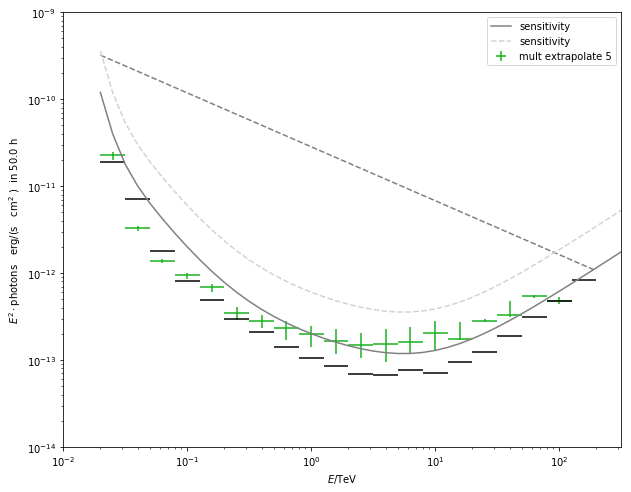

In [161]:
plt.figure(figsize=(10, 8))

# plot_sensitivity(rs_smooth, crab, bin_edges, bin_center, color='blue')

# plot_sensitivity(rs_simple, crab, bin_edges, bin_center, color='crimson', label='0.2')
# plot_sensitivity(rs_mult, crab, bin_edges, bin_center, color='green', label='mult ')
# plot_sensitivity(rs_mult_exact, crab, bin_edges, bin_center, color='xkcd:lime', label='mult exact')
#plot_sensitivity(rs_mult_extrapolate, crab, bin_edges, bin_center, color='xkcd:royal', label='mult extrapolate')
plot_sensitivity(rs_mult_extrapolate_5, crab, bin_edges, bin_center, color='xkcd:green', label='mult extrapolate 5')
# plot_sensitivity(rs_exact, crab, bin_edges, bin_center, color='blue', label='exact 0.2')

# plot_sensitivity(rs_interpolate, crab, bin_edges, bin_center, color='blue', label='interpolate')
# plot_sensitivity(rs_exact, crab, bin_edges, bin_center, color='green', label='exact')
# plt.ylim([10**(-13.4), 1E-10])
plt.xlim([1E-2, 10**(2.5)])
plt.legend()

# plot_sensitivity(rs_simple_02, crab, bin_edges, bin_center, color='blue')


# plot_sensitivity(rs_smooth_02, crab, bin_edges, bin_center, color='navy')

## PREVIUSLY ON THIS CHANNEL:




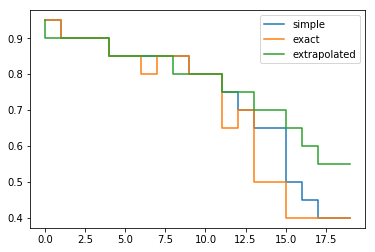

In [148]:
plt.step(rs_mult.index, rs_mult.threshold, label='simple')
plt.step(rs_mult_exact.index, rs_mult_exact.threshold, label='exact')
plt.step(rs_mult_extrapolate.index, rs_mult_extrapolate.threshold, label='extrapolated')
plt.legend()

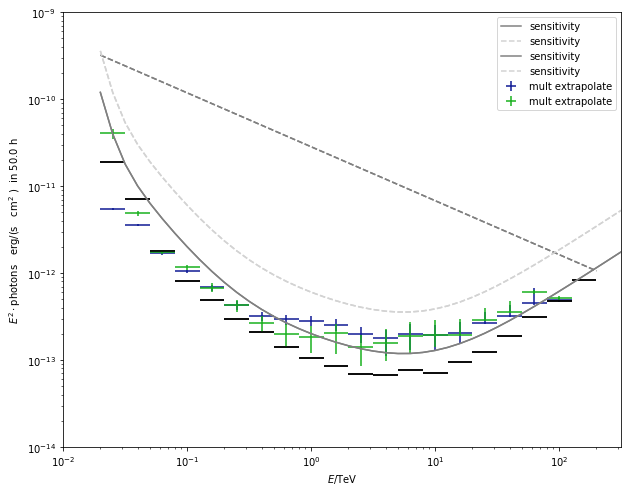

In [151]:
plt.figure(figsize=(10, 8))

# plot_sensitivity(rs_smooth, crab, bin_edges, bin_center, color='blue')

# plot_sensitivity(rs_simple, crab, bin_edges, bin_center, color='crimson', label='0.2')
# plot_sensitivity(rs_mult, crab, bin_edges, bin_center, color='green', label='mult ')
# plot_sensitivity(rs_mult_exact, crab, bin_edges, bin_center, color='xkcd:lime', label='mult exact')
plot_sensitivity(rs_mult_extrapolate, crab, bin_edges, bin_center, color='xkcd:royal', label='mult extrapolate')
plot_sensitivity(rs_mult_extrapolate_5, crab, bin_edges, bin_center, color='xkcd:green', label='mult extrapolate')
# plot_sensitivity(rs_exact, crab, bin_edges, bin_center, color='blue', label='exact 0.2')

# plot_sensitivity(rs_interpolate, crab, bin_edges, bin_center, color='blue', label='interpolate')
# plot_sensitivity(rs_exact, crab, bin_edges, bin_center, color='green', label='exact')
# plt.ylim([10**(-13.4), 1E-10])
plt.xlim([1E-2, 10**(2.5)])
plt.legend()

# plot_sensitivity(rs_simple_02, crab, bin_edges, bin_center, color='blue')


# plot_sensitivity(rs_smooth_02, crab, bin_edges, bin_center, color='navy')

In [127]:
def plot_propaganda(rs, crab, bin_edges, bin_center, color='blue', **kwargs):
    sensitivity = rs.sensitivity.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_low = rs.sensitivity_low.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    sensitivity_high = rs.sensitivity_high.values * (crab.flux(bin_center) * bin_center**2).to(u.erg / (u.s * u.cm**2))
    xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
    yerr = [np.abs(sensitivity - sensitivity_low).value, np.abs(sensitivity - sensitivity_high).value]
    plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, yerr=yerr, linestyle='', ecolor=color, **kwargs)

    plt.xscale('log')
    plt.yscale('log')
    plt.ylim([1E-14, 1E-9])
    

  #  xerr = [np.abs(bin_edges[:-1] - bin_center).value, np.abs(bin_edges[1:] - bin_center).value]
   # plt.errorbar(bin_center.value, sensitivity.value, xerr=xerr, linestyle='', color='black',)

    
    path = '../resources/sensitivity_requirement_south_50.txt'
    df = pd.read_csv(path, delim_whitespace=True, names=['log_energy', 'sensitivity'], index_col=False,  engine='python')
    df['energy'] = 10**df.log_energy
    #plt.plot(df.energy, df.sensitivity, color='gray')
    plt.plot(df.energy, df.sensitivity * 3, color='#273187', linestyle='-', label='official requirement')
    
    plt.ylabel(r'$ E^2 \cdot \mathrm{photons} \quad \mathrm{erg} /( \mathrm{s} \quad  \mathrm{cm}^2$ )  in ' + str(t_obs.to('h')) )
    plt.xlabel(r'$E /  \mathrm{TeV}$')
    plt.legend()


Text(0.5,0,'Energy / TeV')

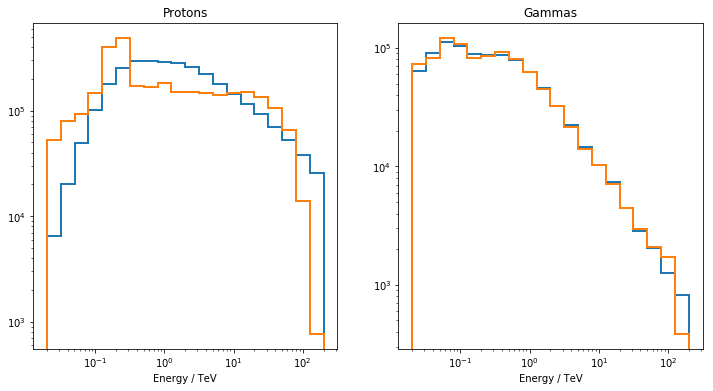

In [76]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1.hist(protons.mc_energy, bins=bin_edges, histtype='step', lw=2)
ax1.hist(protons.gamma_energy_prediction_mean, bins=bin_edges, histtype='step', lw=2)
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_title('Protons')
ax1.set_xlabel('Energy / TeV')

ax2.hist(gammas.mc_energy, bins=bin_edges, histtype='step', lw=2)
ax2.hist(gammas.gamma_energy_prediction_mean, bins=bin_edges, histtype='step', lw=2)
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_title('Gammas')
ax2.set_xlabel('Energy / TeV')